# Initialization

In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo
from IPython.display import display, clear_output
from time import sleep
from glob import glob
from pathlib import Path
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-02-25 13:21:27,002	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# env config
import gymnasium as gym
import platoonenv

env_name = "Platoon-v6"
env_config=dict(
    num_vehicles=10,
    steps_before_truncation=200,
    attack_interval=2,
    cycle_interval=2,
    cycle_num=1,
)
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config,
)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v6 
------------------
reward_threshold None
max_episode_steps None


In [4]:
from ray.rllib.utils import check_env

check_env(env)

2023-02-25 13:21:30,518	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

config = (
    PPOConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=10)
    # .rollouts(num_rollout_workers=0) # curiosity doesn't support parallelism
    .resources(num_gpus=1)
    # .exploration( # https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#curiosity-icm-intrinsic-curiosity-module
    #     exploration_config={
    #         "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    #         "eta": 1.0,  # Weight for intrinsic rewards before being added to extrinsic ones.
    #         "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    #         "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    #         # Setup of the feature net (used to encode observations into feature (latent) vectors).
    #         "feature_net_config": {
    #             "fcnet_hiddens": [],
    #             "fcnet_activation": "relu",
    #         },
    #         "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    #         "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    #         "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    #         "forward_net_activation": "relu",  # Activation of the "forward" model.
    #         "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    #         # Specify, which exploration sub-type to use (usually, the algo's "default"
    #         # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
    #         "sub_exploration": {
    #             "type": "StochasticSampling",
    #         }
    #     }
    # )
)

# config = (
#     DQNConfig()
#     .environment(env=env_name, env_config=env_config)
#     .framework("torch")
#     .rollouts(num_rollout_workers=10)
#     .resources(num_gpus=1)
# )

config.horizon = env.spec.max_episode_steps
config.lr = 0.0001
config.create_env_on_local_worker=True

In [6]:
algo = config.build()

(RolloutWorker pid=2000) 2023-02-25 13:21:44,451	INFO policy.py:1196 -- Policy (worker=6) running on CPU.
(RolloutWorker pid=2000) 2023-02-25 13:21:44,452	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=2452) 2023-02-25 13:21:44,492	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=2452) 2023-02-25 13:21:44,549	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=2452) 2023-02-25 13:21:44,549	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=2080) 2023-02-25 13:21:44,832	INFO policy.py:1196 -- Policy (worker=10) running on CPU.
(RolloutWorker pid=2080) 2023-02-25 13:21:44,832	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=9828) 2023-02-25 13:21:44,873	INFO policy.py

In [7]:
config.env_config

{'num_vehicles': 10,
 'steps_before_truncation': 200,
 'attack_interval': 2,
 'cycle_interval': 2,
 'cycle_num': 1}

In [8]:
# config.to_dict()

In [9]:
import ipywidgets as widgets

suffix = "grow-1"
save_dir = Path("saved_models",f"{env_name}-{str(algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
save_dir.mkdir(parents=True, exist_ok=True)
print(save_dir)

saved_models\Platoon-v6-PPO-10vehicles-grow-1


In [10]:
checkpoints = sorted(glob(str(Path("saved_models","**","checkpoint_*"))))
found = glob(str(save_dir / "*"))
if len(found) == 0:
    checkpoint_path = None
else:
    checkpoint_path = sorted(found)[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=checkpoint_path,
    description='Checkpoint:'
)

def on_change(change):
    global checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        checkpoint_path = change['new']

w.observe(on_change)
display(w)

Dropdown(description='Checkpoint:', layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-curious…

In [11]:
checkpoint_path = None

In [12]:
if checkpoint_path is not None:
    print(f"Restoring from checkpoint: {checkpoint_path}")
    algo.restore(checkpoint_path)

# Training

In [13]:
def plot(rewards_history):
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.title("Training...")
    plt.xlabel("Step")
    plt.ylabel("Rewards")
    plt.plot([x["episode_reward_mean"] for x in rewards_history])
    plt.grid(alpha=0.2)
    plt.show()

In [14]:
results_history = []

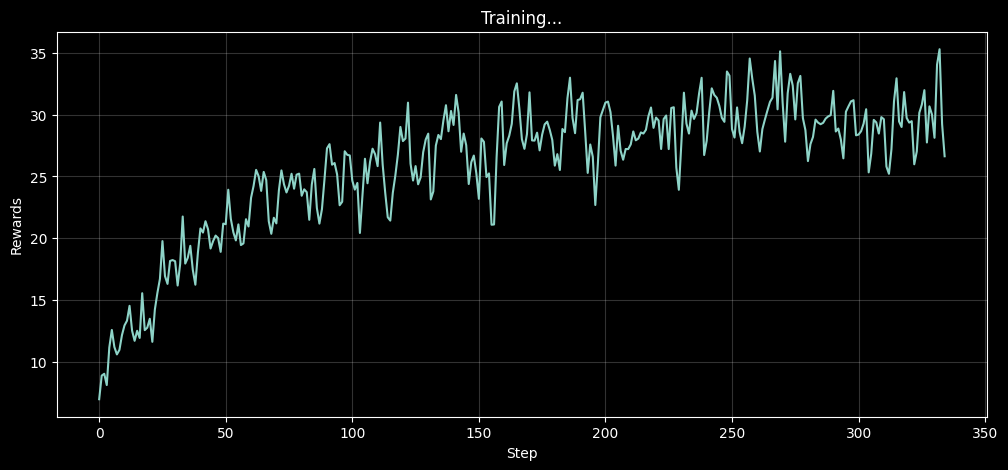

reward mean=26.64 iteration=335: : 3618.3086977005005it [1:01:05,  1.01s/it]


saved_models\Platoon-v6-PPO-10vehicles-grow-1\checkpoint_000335


In [15]:
import time
train_time = 60*60*1
plot_every = 1
save_every = 100

current = algo.get_state()["time_total"]
with tqdm(total=train_time) as pbar:
    pbar.update(current)
    for i in count():
        try:
            start = time.time()
            results = algo.train()
            end = time.time()
            delta = end - start
            pbar.update(delta)
            results_history.append(results)
        except KeyboardInterrupt:
            print("Interrupting training")
            checkpoint_path = algo.save(save_dir)
            print(f"Checkpoint saved at: {checkpoint_path}")
            break

        if i % plot_every == 0:
            plot(results_history)
            
        pbar.set_description(f"reward mean={results['episode_reward_mean']:.02f} iteration={algo.get_state()['iteration']}")
        pbar.display()

        if algo.get_state()["iteration"] % save_every == 0:
            algo.save(save_dir)
        if algo.get_state()["time_total"] >= train_time:
            print(algo.save(save_dir))
            break

# training done, play sound to notify
from winsound import Beep
Beep(300, 2000)

In [16]:
print(algo.save(save_dir))
# checkpoint path is grabbed by glob when restoring earlier

saved_models\Platoon-v6-PPO-10vehicles-grow-1\checkpoint_000335


In [24]:
import json
json.dump([x["episode_reward_mean"] for x in results_history], open(save_dir / f"results-{str(algo)}-step{i+1}.json", "w"))

In [23]:
{k:v for k,v in algo.get_state().items() if k != "last_result"}

{'experiment_id': 'c155813fd6d94d078a37dccebb18442d',
 'iteration': 335,
 'timesteps_total': None,
 'time_total': 3606.120593070984,
 'episodes_total': 17414,
 'ray_version': '3.0.0.dev0'}

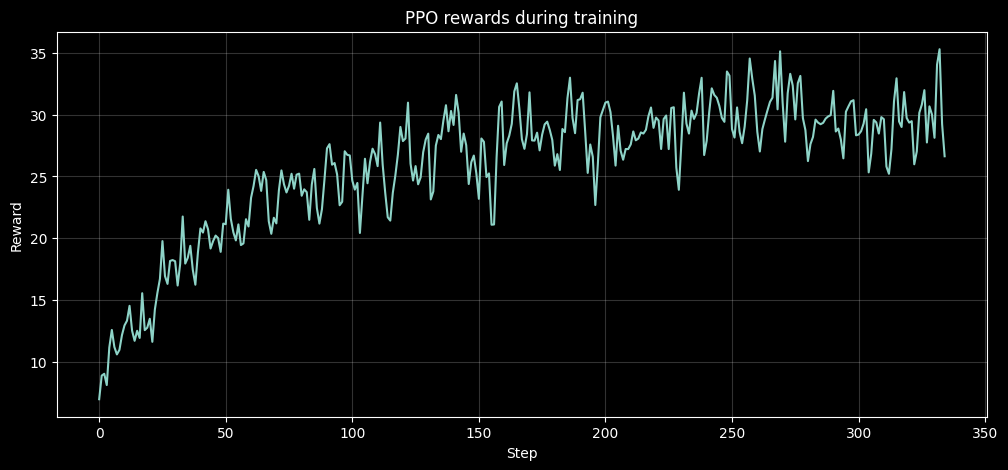

In [26]:
plt.figure(figsize=(12, 5))
plt.title(f"{str(algo)} rewards during training")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(alpha=0.2)
plt.plot([x["episode_reward_mean"] for x in results_history])
# plt.show()
figdir = Path("figures","training")
figdir.mkdir(exist_ok=True)
plt.savefig(figdir / f"rewards-{str(algo)}-step{i+1}.png", format="png", dpi=300, bbox_inches="tight")

In [20]:
results["info"]

{'learner': {'default_policy': {'custom_metrics': {},
   'learner_stats': {'cur_kl_coeff': 1.5187500000000005,
    'cur_lr': 0.00010000000000000003,
    'total_loss': 7.768656566186297,
    'policy_loss': -0.12118373420590195,
    'vf_loss': 7.866605463527864,
    'vf_explained_var': -0.07003058464296402,
    'kl': 0.015298651938894178,
    'entropy': 0.8774753503901984,
    'entropy_coeff': 0.0},
   'model': {},
   'num_grad_updates_lifetime': 311085.5,
   'diff_num_grad_updates_vs_sampler_policy': 464.5}},
 'num_env_steps_sampled': 1340000,
 'num_env_steps_trained': 1340000,
 'num_agent_steps_sampled': 1340000,
 'num_agent_steps_trained': 1340000}

In [21]:
algo.evaluate()

2023-02-25 14:22:56,493	INFO algorithm.py:882 -- Evaluating current policy for 10 episodes.
2023-02-25 14:22:56,494	INFO rollout_worker.py:905 -- Generating sample batch of size 400
2023-02-25 14:22:56,495	INFO sampler.py:610 -- Raw obs from env: { 0: { 'agent0': np.ndarray((100,), dtype=float32, min=0.0, max=5.0, mean=0.629)}}
2023-02-25 14:22:56,496	INFO sampler.py:611 -- Info return from env: { 0: { 'agent0': { 'action': -1,
                   'attacker_action': -1,
                   'cycled': [],
                   'members': np.ndarray((10,), dtype=float32, min=0.0, max=0.0, mean=0.0),
                   'modes': np.ndarray((10,), dtype=float32, min=0.0, max=0.0, mean=0.0),
                   'obs_probs': np.ndarray((10, 4), dtype=float32, min=0.0, max=0.936, mean=0.298),
                   'probs': np.ndarray((10, 4), dtype=float32, min=0.0, max=0.936, mean=0.298),
                   'reward': 0,
                   'severities': np.ndarray((10, 4), dtype=float32, min=0.0, max=5.

{'evaluation': {'episode_reward_max': 88.80000000000014,
  'episode_reward_min': 0.1,
  'episode_reward_mean': 33.22558139534883,
  'episode_len_mean': 91.37209302325581,
  'episode_media': {},
  'episodes_this_iter': 43,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [36.7,
    32.3,
    8.700000000000001,
    36.00000000000001,
    51.49999999999996,
    76.2000000000001,
    4.1,
    1.6,
    68.99999999999994,
    15.600000000000001,
    87.3999999999999,
    74.40000000000003,
    5.6,
    47.499999999999936,
    11.1,
    9.5,
    88.80000000000014,
    2.3000000000000003,
    68.29999999999998,
    6.6000000000000005,
    0.5,
    24.200000000000006,
    6.200000000000001,
    37.99999999999996,
    45.2,
    25.299999999999994,
    82.50000000000001,
    1.4,
    17.600000000000005,
    2.6,
    0.1,
    35.699999999999974,
    61.99999999999996,
    25.399999999999995,
    46.79999999

In [22]:
algo._counters

defaultdict(int,
            {'num_env_steps_sampled': 1340000,
             'num_env_steps_trained': 1340000,
             'num_agent_steps_sampled': 1340000,
             'num_agent_steps_trained': 1340000})